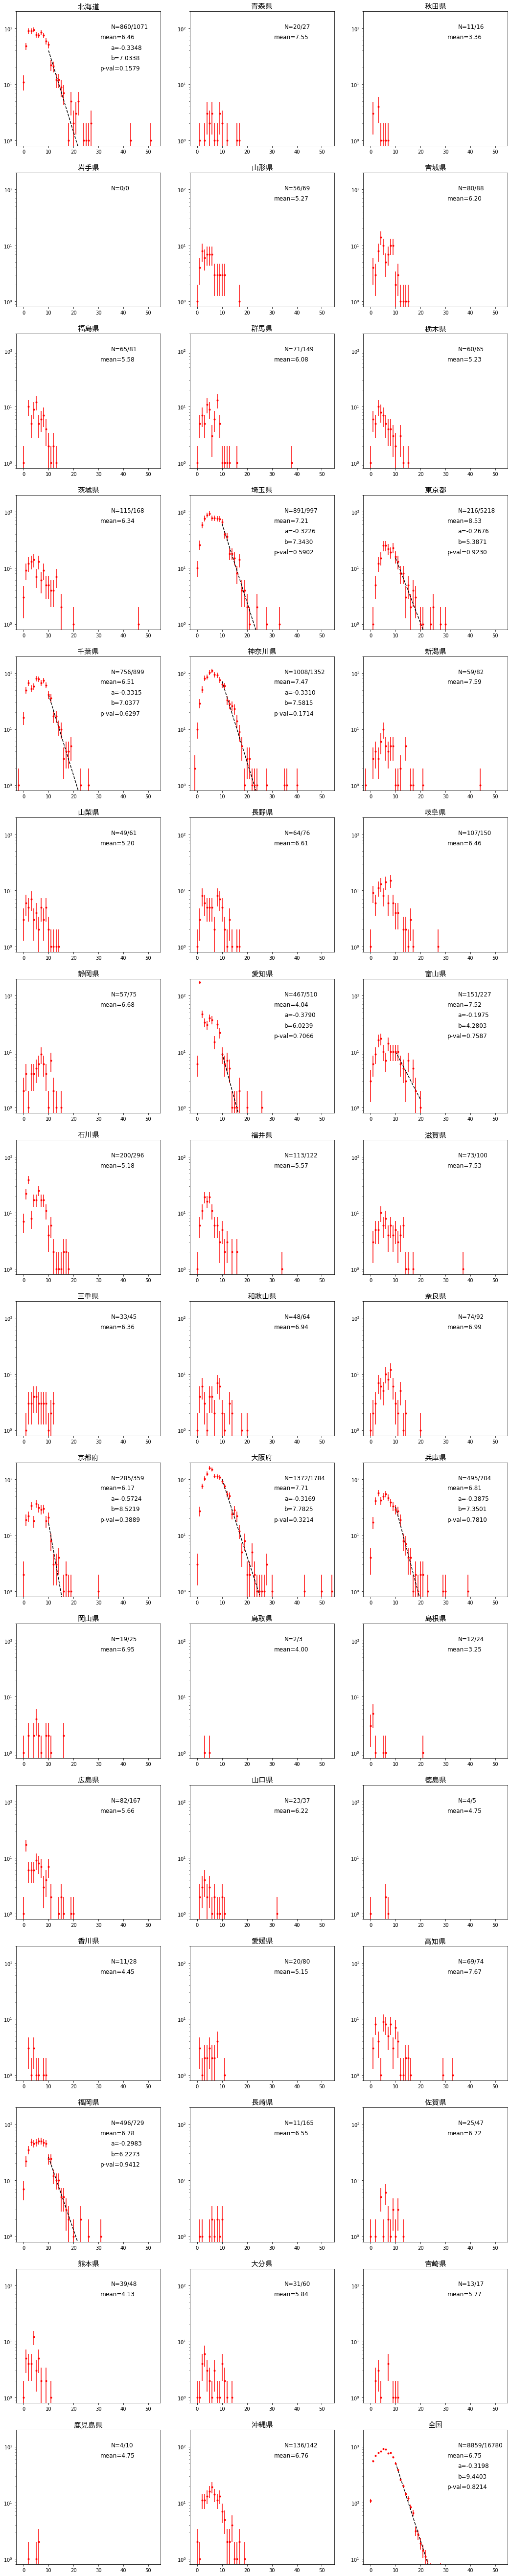

<Figure size 28800x153600 with 0 Axes>

In [11]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import os
from lmfit import Model

PREF = ('北海道','青森県','秋田県','岩手県','山形県','宮城県','福島県','群馬県','栃木県','茨城県','埼玉県',
        '東京都','千葉県','神奈川県','新潟県','山梨県','長野県','岐阜県','静岡県','愛知県','富山県','石川県',
        '福井県','滋賀県','三重県','和歌山県','奈良県','京都府','大阪府','兵庫県','岡山県','鳥取県','島根県',
        '広島県','山口県','徳島県','香川県','愛媛県','高知県','福岡県','長崎県','佐賀県','熊本県','大分県',
        '宮崎県','鹿児島県','沖縄県')

def func(x,a,b):
    return np.exp(a*x+b)

def remove_fit(rmx,rmy, strtp, stpp):
    start = rmx.index(strtp)
    stop = start + stpp - strtp
    gmodel = Model(func)
    dx = np.array([])
    frt = np.array([])
    frter = np.array([])
    for i in range(start,min(stop+1, len(rmy))):
        if rmy[i] > 0 and rmx[i]<=stop :
            dx = np.append(dx, float(rmx[i]))
            frt = np.append(frt, rmy[i])
            frter = np.append(frter, np.sqrt(rmy[i]))
    frtw = 1.0/frter
    result = gmodel.fit(data=frt, x=dx, weights=frtw,a=0., b=10.0)
    #result = gmodel.fit(data=frt, x=dx, weights=frtw)
    a = result.best_values['a']
    b = result.best_values['b']
    chisq = result.chisqr
    pval = 1.-stats.chi2.cdf(result.chisqr,result.nfree)
    frtfunc = func(dx,a,b)
    return dx,frtfunc,a,b,chisq,pval

JDAT = os.environ['JAGJDATA']+'/'+'COVID-19.csv'
jdat = pd.read_csv(JDAT,usecols=['通し','確定日','発症日','受診都道府県','居住都道府県','ステータス','人数'],
                  dtype={'確定日':str,'発症日':str,'受診都道府県':str,'居住都道府県':str,'ステータス':str})
#lastinx = np.where(np.isnan(jdat['通し']))[0][0]  # 通し番号なし以後は空行，有効最終行インデクス
#njdat = jdat[:lastinx]  # 空行を削除
njdat = jdat
njdat.loc[:,('確定日')] = pd.to_datetime(njdat['確定日']) # 年月日形式へ変換
njdat.loc[:,('発症日')] = pd.to_datetime(njdat['発症日'])
hjdat = njdat.sort_values('発症日')  # これで発症日データ無しの行は後尾へ移動
lastinx = np.where(np.isnan(hjdat['発症日']))[0][0]  # 有効データの最後尾インデクス
hjdat = hjdat[:lastinx]  # 発症日データが無い行を削除
hkan = ((hjdat['確定日']-hjdat['発症日']).dt.days).value_counts().sort_index() # 確定日-発症日の同数分布(全国)

igfont = {'family':'IPAexGothic'}
pfig, pax = plt.subplots(int(np.ceil(len(PREF)/3.0)),3,figsize=(18,6*int(np.ceil(len(PREF)/3.0))))
ip = 0
for pref in PREF:
    pax[int(ip/3),ip%3].set_yscale('log')
    pax[int(ip/3),ip%3].set_ylim(0.8,200)
    pax[int(ip/3),ip%3].set_xlim(-3,55)
    pax[int(ip/3),ip%3].set_title(pref,**igfont,fontsize=15)
    phjdat = hjdat[hjdat['受診都道府県']==pref]
    phkan = ((phjdat['確定日']-phjdat['発症日']).dt.days).value_counts().sort_index()
    if phkan[10:].sum() > 30:
        rslt = remove_fit(phkan.index.tolist(),phkan.tolist(),10,25)
        #pax[int(ip/3),ip%3].text(35,100,'N='+str(phkan.sum()),fontsize=12)
        pax[int(ip/3),ip%3].text(30.8,65,'mean='+'{:.2f}'.format(np.dot(phkan.index,phkan)/phkan.sum()),fontsize=12)
        pax[int(ip/3),ip%3].text(35,42.25,'a='+'{:.4f}'.format(rslt[2]),fontsize=12)
        pax[int(ip/3),ip%3].text(35,27.46,'b='+'{:.4f}'.format(rslt[3]),fontsize=12)
        pax[int(ip/3),ip%3].text(30.8,17.85,'p-val='+'{:.4f}'.format(rslt[5]),fontsize=12)
        pax[int(ip/3),ip%3].plot(rslt[0],rslt[1],'k--')
    else:
        #pax[int(ip/3),ip%3].text(35,100,'N='+str(phkan.sum()),fontsize=12)
        if phkan.sum() > 0:
            pax[int(ip/3),ip%3].text(30.8,65,'mean='+'{:.2f}'.format(np.dot(phkan.index,phkan)/phkan.sum()),fontsize=12)
    pax[int(ip/3),ip%3].text(35,100,'N='+str(phkan.sum())+'/'+str(len(njdat[njdat['受診都道府県']==pref])),fontsize=12)
    pax[int(ip/3),ip%3].errorbar(phkan.index,phkan,yerr=np.sqrt(phkan),fmt='ro',markersize=3)
    ip += 1
rslt = remove_fit(hkan.index.tolist(),hkan.tolist(),10,25)
pax[int(ip/3),ip%3].text(35,1000,'N='+str(hkan.sum())+'/'+str(len(njdat)),fontsize=12)
pax[int(ip/3),ip%3].text(30.8,650,'mean='+'{:.2f}'.format(np.dot(hkan.index,hkan)/hkan.sum()),fontsize=12)
pax[int(ip/3),ip%3].text(35,422.5,'a='+'{:.4f}'.format(rslt[2]),fontsize=12)
pax[int(ip/3),ip%3].text(35,274.6,'b='+'{:.4f}'.format(rslt[3]),fontsize=12)
pax[int(ip/3),ip%3].text(30.8,178.5,'p-val='+'{:.4f}'.format(rslt[5]),fontsize=12)
pax[int(ip/3),ip%3].plot(rslt[0],rslt[1],'k--')
pax[int(ip/3),ip%3].set_yscale('log')
pax[int(ip/3),ip%3].set_ylim(8,2000)
pax[int(ip/3),ip%3].set_xlim(-3,55)
pax[int(ip/3),ip%3].set_title('全国',**igfont,fontsize=15)
pax[int(ip/3),ip%3].errorbar(hkan.index,hkan,yerr=np.sqrt(hkan),fmt='ro',markersize=3)

plt.show()
plt.figure(figsize=(18,6*int(np.ceil(len(PREF)/3.0))), dpi=1600)
pfig.savefig('test.png',bbox_inches='tight')

#### 東京都の発症日データの少なさ
東京都の発症日データの最終レコードは3月26日である．これを最後にして東京都は感染者の発症日追跡を諦めたらしい．これと比較すると，感染者が多い北海道，大阪府，神奈川県，埼玉県，千葉県の努力は際立っている．  
また，東京都は発症日から確定日までの平均に数が他県と比べ大きいだけでなく，分布の勾配が明らかに小さい．これには色々な理由を考え得るが，すぐに思い当たるのはPCR検査(感染者発見)への消極性だろう．